# Lab 6: Confidence Intervals

## William Olsen, partners with Jennifer Vo

Within this lab we will be using the data from the LHC in order to explore confidence intervals around measuring the Higgs.  This lab will be more focused on exploring the background rather than doing an in-depth exploration for the Higgs.

From work done in the previous lab, we identified that when searching for the Higgs Boson the background distribution at the ATLAS detector at the LHC is a Poisson distribution.  We will be using a Poisson distribution with parameter 100 which is not the same as the true parameter for the distribution but for sake of analysis we will use this parameter.

In [14]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pickle

# general graphing setup
plt.rcParams["figure.figsize"] = (15,10)

## Problem 1

Now with our persumed background - a Poisson distribution with parameter 100 - let's determine the $5\sigma$ sensitivity threshold value for our distribution by answering the following question:

> What value must the background distribution - a Poisson with parameter 100 - produce such that the probability of producing that value is 5-sigma?

Let's answer this question:

In [3]:
def compute_poisson_sigma_value(lambda_, value):
    # determine the probability associated with this value
    value_prob = stats.poisson.sf(value, lambda_)

    # use the inverse survival function to determine the sigma that has the same associated probability
    sigma = stats.norm.isf(value_prob)

    return sigma

def compute_poisson_5sigma_value(lambda_):
    # define the sigma value
    sigma = 5

    # use the inverse survival function to determine the probability associated with 5sigma
    prob_sigma = stats.norm.sf(sigma)
    
    # determine the value associated with this probability
    value = stats.poisson.isf(prob_sigma, lambda_)

    return value

In [4]:
# define our variables
bkgd_lambda = 100

# determine the value associated with a 5-sigma probability
bkgd_5sigma_value = compute_poisson_5sigma_value(bkgd_lambda)
print(f'The value required for a 5-sigma probability for the background is {bkgd_5sigma_value}')

The value required for a 5-sigma probability for the background is 154.0


From the above, we found that the $5\sigma$ sensitivity threshold value for our background distribution - a Poisson with parameter 100 - is 154.0.

## Problem 2

Now we will explore injecting a signal of known strength (between the $8\sigma$ and $30\sigma$ values) into our background many times and we will make observations after doing such.

### Part A

Let's create a histogram for how bright the observed signal is after injecting a true signal of strength $8\sigma$ (which is equivalent to the value 190.0) into our background.

In [38]:
def compute_poisson_specific_sigma_value(sigma, lambda_):
    # use the inverse survival function to determine the probability associated with 5sigma
    prob_sigma = stats.norm.sf(sigma)
    
    # determine the value associated with this probability
    value = stats.poisson.isf(prob_sigma, lambda_)

    return value

# define the inject signal
inject_8sigma_value = compute_poisson_specific_sigma_value(8, bkgd_lambda)

# draw from the background many times
draw_bkgd = stats.poisson.rvs(bkgd_lambda, size=100000)

# inject the signal
bkgd_injected = draw_bkgd + inject_8sigma_value

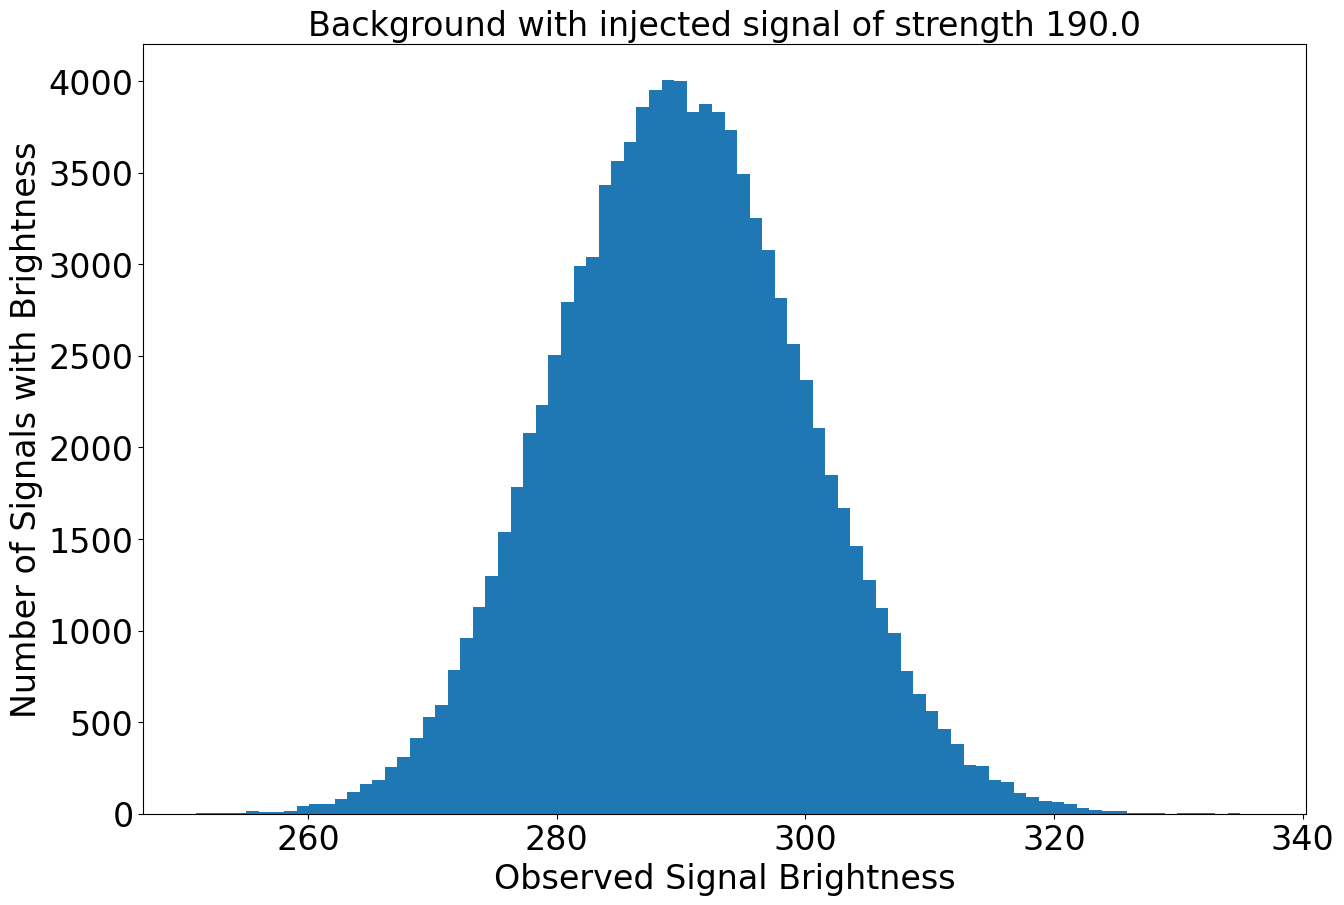

In [41]:
# plot the histogram
fs = 24
plt.hist(bkgd_injected, bins=84)
plt.title('Background with injected signal of strength 190.0', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.xlabel('Observed Signal Brightness', fontsize=fs)
plt.ylabel('Number of Signals with Brightness', fontsize=fs)
plt.show()

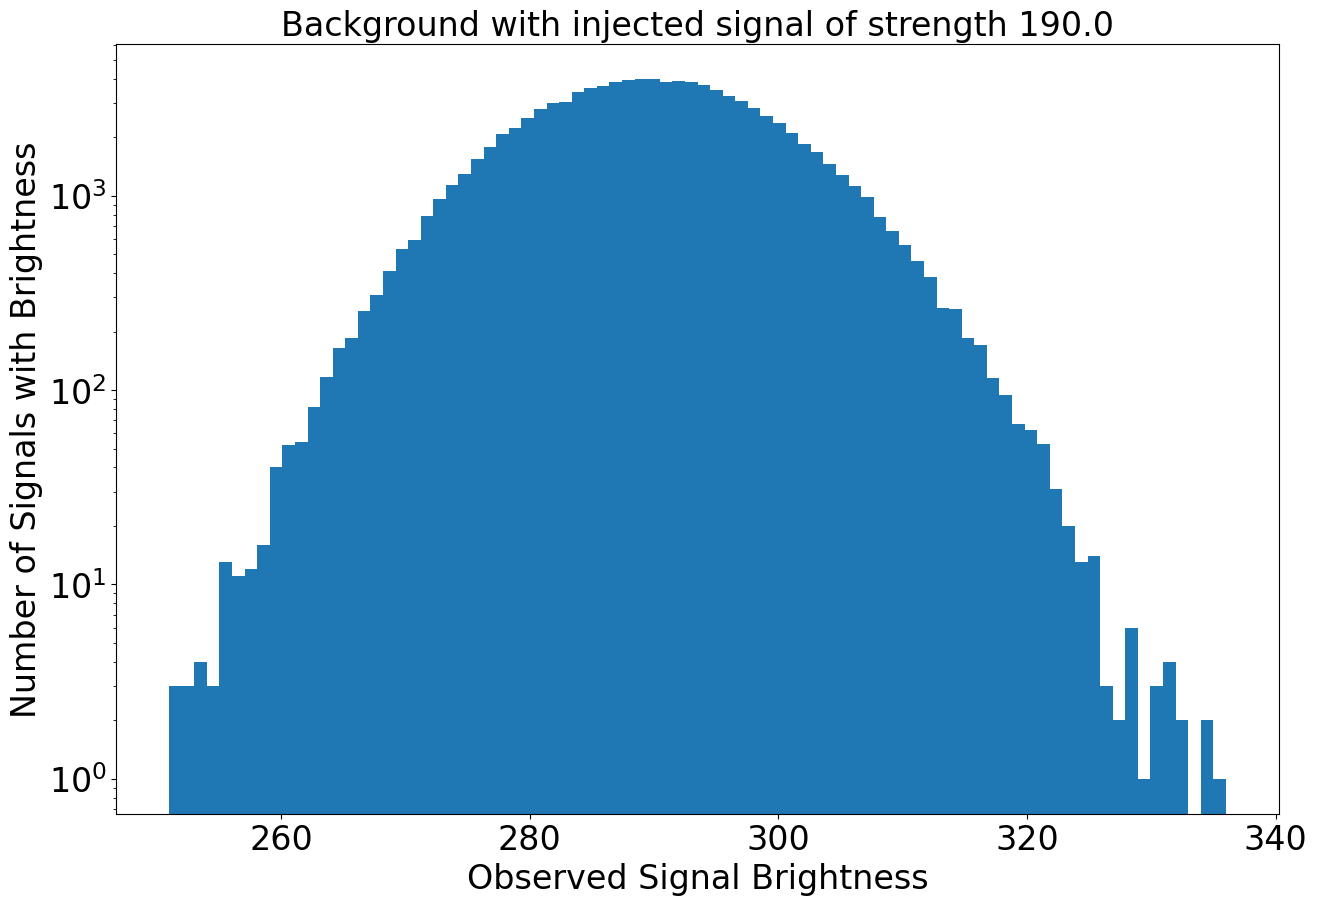

In [42]:
# plot the histogram on log scale
plt.hist(bkgd_injected, bins=84)
plt.title('Background with injected signal of strength 190.0', fontsize=fs)
plt.yscale('log')
plt.tick_params(labelsize=fs)
plt.xlabel('Observed Signal Brightness', fontsize=fs)
plt.ylabel('Number of Signals with Brightness', fontsize=fs)
plt.show()

    TODO write me
    
histogram is a gaussian.  it is telling us what?

### Part B

    TODO : check this

The observed signal is biased as we see that all of the observed signals are stronger than the injected signal.  We also see that our observed signal distribution is symmetric.  Specifically it appears to have converged to a Gaussian distirbution.